#### In this notebook is performed the aplication of the Canny algorithm to Reanalysis data from the Atlantic-Iberian Biscay Irish- Ocean Physics Reanalysis.

First, the Atlantic-Iberian Biscay Irish- Ocean Physics Reanalysis (netCDFs) data is imported and converted to dataframes.

It's perform visualizations of the data, application of Canny with and without the prior use of a Gaussian filter, overlay of the images with the edges detected by Canny, .... A slider is also created to evaluate how the detection of fronts varies with the variation of Thresholds values.

The point of this notebook is to get a deeper understanding of how the canny algorithm works and what can be done with it.


In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import netCDF4 as nc
import cv2
import datetime
import xarray as xr
import os
import cmocean
import matplotlib
from matplotlib.colors import ListedColormap

%matplotlib inline

#### Import Reanalysis data (Atlantic-Iberian Biscay Irish- Ocean Physics Reanalysis)



In [4]:
current_path = os.getcwd()
current_path

'/home/luisfigueiredo/JUNO/notebooks'

In [5]:
from pathlib import Path

data_folder = os.path.join(current_path,"../data")
data_folder

'/home/luisfigueiredo/JUNO/notebooks/../data'

In [6]:
nc_path = os.path.join(data_folder, "IBI2014-2019.nc")
ds = nc.Dataset(nc_path)
data = xr.load_dataset(nc_path)

In [7]:
print(ds)     # data related to the netCDF file

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    Conventions: CF-1.0
    source: CMEMS IBI-MFC
    institution: Puertos del Estado (PdE) - Mercator-Ocean (MO)
    references: http://marine.copernicus.eu
    title: CMEMS IBI REANALYSIS: DAILY PHYSICAL PRODUCTS 
    easting: longitude
    northing: latitude
    domain_name: IBI12
    FROM_ORIGINAL_FILE__field_type: mean
    field_date: 20191224
    FROM_ORIGINAL_FILE__longitude_min: -19.f
    FROM_ORIGINAL_FILE__longitude_max: 5.f
    FROM_ORIGINAL_FILE__latitude_min: 26.f
    FROM_ORIGINAL_FILE__latitude_max: 56.f
    z_min: 0.50576f
    z_max: 5698.061f
    contact: mailto: servicedesk.cmems@mercator-ocean.eu
    bulletin_date: 2020-12-01
    bulletin_type: Reanalysis
    _CoordSysBuilder: ucar.nc2.dataset.conv.CF1Convention
    comment: 
    history: Data extracted from dataset http://localhost:8080/thredds/dodsC/cmems_mod_ibi_phy_my_0.083deg-3D_P1D-m
    dimensions(sizes): depth(1), latitude(1

In [8]:
#Convert netCDF file to a dataframe
datadf = data.to_dataframe()
datadf2 = datadf.reset_index()

In [9]:
datadf2 = datadf2.drop(['depth'], axis=1)     #drop column 'depth' (not necessary)
datadf2    # now the data is in the dataframe format

,latitude,longitude,time,thetao
0,35.0,-19.0,2014-01-01 12:00:00,18.316000
1,35.0,-19.0,2014-01-02 12:00:00,18.309000
2,35.0,-19.0,2014-01-03 12:00:00,18.316000
3,35.0,-19.0,2014-01-04 12:00:00,18.273001
4,35.0,-19.0,2014-01-05 12:00:00,18.230000
...,...,...,...,...
44660611,45.0,-5.0,2019-12-20 12:00:00,13.619000
44660612,45.0,-5.0,2019-12-21 12:00:00,13.559000
44660613,45.0,-5.0,2019-12-22 12:00:00,13.458000
44660614,45.0,-5.0,2019-12-23 12:00:00,13.400000


In [10]:
datadf2 = datadf2[['time', 'latitude', 'longitude', 'thetao']]    #reorder the dataframe columns
datadf2

,time,latitude,longitude,thetao
0,2014-01-01 12:00:00,35.0,-19.0,18.316000
1,2014-01-02 12:00:00,35.0,-19.0,18.309000
2,2014-01-03 12:00:00,35.0,-19.0,18.316000
3,2014-01-04 12:00:00,35.0,-19.0,18.273001
4,2014-01-05 12:00:00,35.0,-19.0,18.230000
...,...,...,...,...
44660611,2019-12-20 12:00:00,45.0,-5.0,13.619000
44660612,2019-12-21 12:00:00,45.0,-5.0,13.559000
44660613,2019-12-22 12:00:00,45.0,-5.0,13.458000
44660614,2019-12-23 12:00:00,45.0,-5.0,13.400000


In [11]:
#Dataframe with data related to a specific day (in this case 1st of August 2019)
Aug1 = datadf2[datadf2['time'] == '2019-08-01 12:00:00']
Aug1

,time,latitude,longitude,thetao
2038,2019-08-01 12:00:00,35.0,-19.000000,23.055000
4222,2019-08-01 12:00:00,35.0,-18.916666,23.020000
6406,2019-08-01 12:00:00,35.0,-18.833334,22.988001
8590,2019-08-01 12:00:00,35.0,-18.750000,22.988001
10774,2019-08-01 12:00:00,35.0,-18.666666,23.003000
...,...,...,...,...
44651734,2019-08-01 12:00:00,45.0,-5.333334,19.706001
44653918,2019-08-01 12:00:00,45.0,-5.250000,19.806000
44656102,2019-08-01 12:00:00,45.0,-5.166667,19.884001
44658286,2019-08-01 12:00:00,45.0,-5.083334,19.917000


### 1st Plot SST Map

Using the dataframe for a specific day, a pivot_table will be created and then a contour will be plotted to see the SST map

In [12]:
#drop column 'time'
Aug1 = Aug1.drop(['time'], axis=1)
Aug1

,latitude,longitude,thetao
2038,35.0,-19.000000,23.055000
4222,35.0,-18.916666,23.020000
6406,35.0,-18.833334,22.988001
8590,35.0,-18.750000,22.988001
10774,35.0,-18.666666,23.003000
...,...,...,...
44651734,45.0,-5.333334,19.706001
44653918,45.0,-5.250000,19.806000
44656102,45.0,-5.166667,19.884001
44658286,45.0,-5.083334,19.917000


In [13]:
#Convert df to a pivot table 
Temp = Aug1.pivot_table(index='longitude', columns='latitude', values='thetao').T.values

long_unique = np.sort(Aug1['longitude'].unique())
lat_unique = np.sort(Aug1['latitude'].unique())
X, Y = np.meshgrid(long_unique, lat_unique)

In [14]:
Temp.shape #shape (nr of rows, nr of columns) of Array Temp

(121, 169)

/tmp/ipykernel_17607/80628514.py:2: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg')


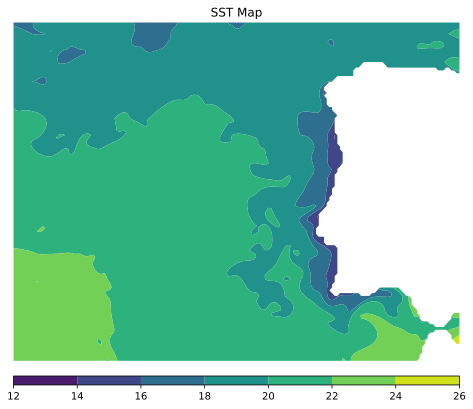

In [15]:
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')

plt.rcParams['figure.figsize'] = 8,7 # sets plot size
fig = plt.figure()
ax = fig.add_subplot(111)

# Generate a color mapping of the levels we've specified
import matplotlib.cm as cm # matplotlib's color map library
cpf = ax.contourf(X,Y,Temp, 5, cmap=cm.viridis)

plt.axis('off');         #To remove image labels
plt.colorbar(cpf, orientation='horizontal', fraction=0.07, pad=0.04, aspect=50);
plt.title('SST Map');
 

## --------------------------------------------------------------------------------------------------------------
## Apply Canny to array in format uint8, with values between 0 and 255


In [ ]:
#Matrix with temperature values between 0-255
Temp_aux5 = ((Temp - np.nanmin(Temp)) * (1/(np.nanmax(Temp) - np.nanmin(Temp)) * 255)).astype('uint8')
Temp_aux5 = np.flipud(Temp_aux5)  
Temp_aux5

In [ ]:
#Plot the numpy array
im3 = plt.imshow(Temp_aux5, cmocean.cm.thermal)
plt.rcParams["figure.figsize"] = (7,7)
plt.colorbar(im3, orientation='horizontal', fraction=0.07, pad=0.08, aspect=50)
plt.show()

In [21]:
def canny_visualization(df, Tmax):
    
    """
    Function that takes a df with SST (Sea Surface Temperature) data of a certain day and 
    plots a map with the defined edges using the Canny Algorithm
    """
    
    plt.rcParams["figure.figsize"] = 12, 8
    
  
    Temp = df.pivot_table(index='longitude', columns='latitude', values='thetao').T.values
    
    #Convert the temperature values to the format uint8 with values between 0-255
    Temp_day = ((Temp - np.nanmin(Temp)) * (1/(np.nanmax(Temp) - np.nanmin(Temp)) * 255)).astype('uint8')

    Temp_day = np.flipud(Temp_day)   #flipud -> Reverse the order of elements along axis 0 (up/down).
    
    #apply the canny algorithm to the data
    canny = cv2.Canny(Temp_day, Tmax/2, Tmax, L2gradient=False, apertureSize=3)
    
    lat = df['latitude'].to_numpy()   
    lon = df['longitude'].to_numpy()
    lat = np.unique(lat).round(3)
    lon = np.unique(lon).round(3)
    
    #Convert some df to a numpy array with the SST values for each value of longitude and latitude
    sst = df.pivot_table(index='longitude', columns='latitude', values='thetao').T.values  #MELHORAR  
    mask = np.isnan(np.flipud(sst))    #Boolean array is True where original array (Temp) had Null values
    mask255 =np.where(mask,(np.ones(mask.shape))*255,0).astype("uint8")   #array which pixels = 255 when mask=True
    #Make a dilation to ensure the pixels that belong to the shore are not consideredd fronts
    kernel = np.ones((3,3), np.uint8)
    mask_dilated = cv2.dilate(mask255, kernel)
    
    canny = np.ma.masked_where(mask_dilated==255, canny)
    
    
    plt.imshow(canny, cmocean.cm.thermal, extent=[lon[0], lon[-1], lat[0], lat[-1]])    
    plt.title('Canny Algorithm for 1st August 2019 (Reanalysis Data)', fontsize=20)


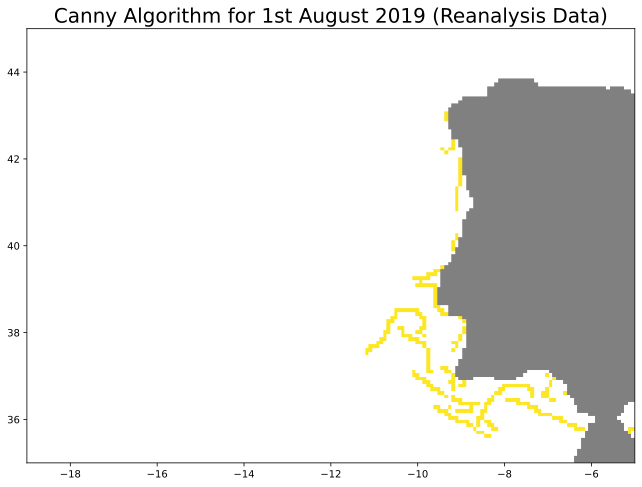

In [22]:
canny_visualization(Aug1, 180)

#### Images in the same cell to ease interpretation


NameError: name 'Temp_aux' is not defined

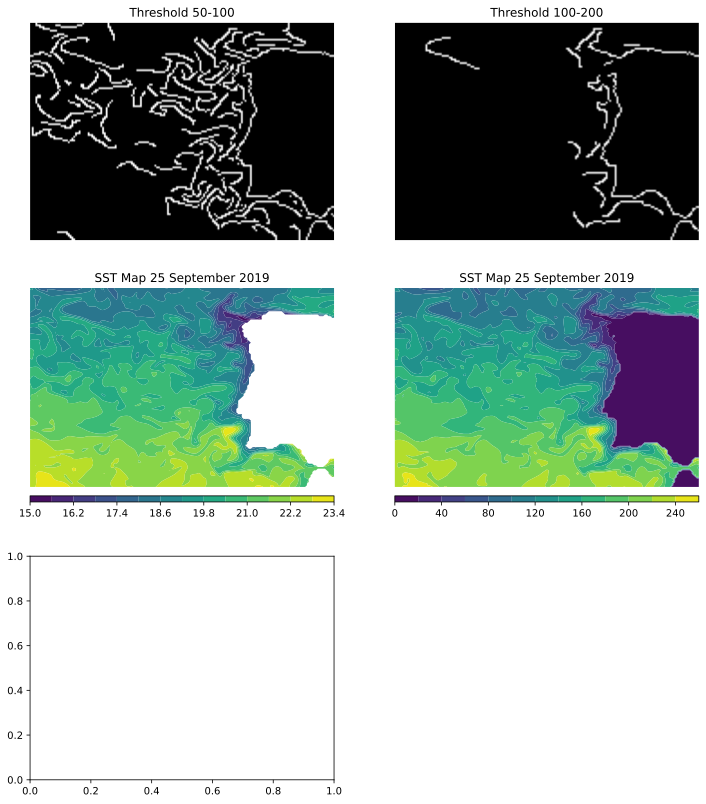

In [18]:
# create figure
fig = plt.figure(figsize=(12, 14))

# setting values to rows and column variables
rows = 2
columns = 2

# Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 1)
#Definition of he canny parameters
Tmax = 100
Tmin= Tmax/2
canny_visualization(dia25, Tmax)
plt.title("Threshold 50-100");

# Adds a subplot at the 2nd position
fig.add_subplot(rows, columns, 2)
canny_visualization(dia25, 2*Tmax)
plt.title("Threshold 100-200");


# Adds a subplot to show the image
ax = fig.add_subplot(rows, columns, 3)
cpf = ax.contourf(X,Y,Temp, 14, cmap=cm.viridis)
plt.axis('off');                 #To remove from the image the labels with longitude and latitude
plt.colorbar(cpf, orientation='horizontal', fraction=0.07, pad=0.04, aspect=50)
plt.title('SST Map 25 September 2019');


# Adds a subplot and show a histogram with the dispersion of the temperature values
ax = fig.add_subplot(rows, columns, 4)
cpf = ax.contourf(X,Y,np.flipud(Temp_aux5), 14, cmap=cm.viridis)
plt.axis('off');       
plt.colorbar(cpf, orientation='horizontal', fraction=0.07, pad=0.04, aspect=50)
plt.title('SST Map 25 September 2019');


fig.add_subplot(rows, columns, 5)
histograma = plt.hist(Temp_aux.flatten(), bins=50);
plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23])
# showing image
plt.title("Histograma valores verdadeiros de temperaturas");
plt.show(histograma);
plt.axis('off');



# ---------------------------------------------------------------------------------------------------
## Canny with Gaussian Filter previously applied

We will apply a gaussian filter with a certain sigma value to sort of reduce the noise in the image (blurs the image) and only after that we will apply the Canny Algorithm


In [18]:
from scipy.ndimage import gaussian_filter

In [19]:
Temp_gauss = Temp_aux5.copy()
Temp_gauss

array([[ 83,  83,  84, ..., 134, 135, 135],
       [ 90,  87,  85, ..., 134, 135, 136],
       [102,  98,  93, ..., 135, 136, 137],
       ...,
       [207, 205, 204, ...,   0,   0,   0],
       [206, 205, 204, ...,   0,   0,   0],
       [206, 205, 204, ...,   0,   0,   0]], dtype=uint8)

In [20]:
Temp_gauss = gaussian_filter(Temp_gauss, sigma=1)  #Sigma -> Standard deviation for Gaussian kernel.
Temp_gauss

array([[ 85,  85,  84, ..., 133, 134, 134],
       [ 90,  88,  87, ..., 133, 134, 135],
       [ 98,  96,  93, ..., 134, 135, 135],
       ...,
       [205, 204, 203, ...,   0,   0,   0],
       [205, 204, 203, ...,   0,   0,   0],
       [205, 204, 204, ...,   0,   0,   0]], dtype=uint8)

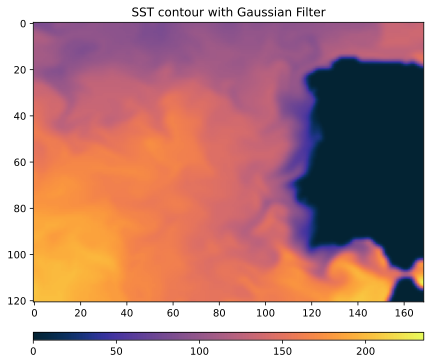

In [21]:
im5 = plt.imshow(Temp_gauss, cmocean.cm.thermal)
plt.rcParams["figure.figsize"] = (7,7)
plt.colorbar(im5, orientation='horizontal', fraction=0.07, pad=0.08, aspect=50)
plt.title('SST contour with Gaussian Filter')
plt.show()

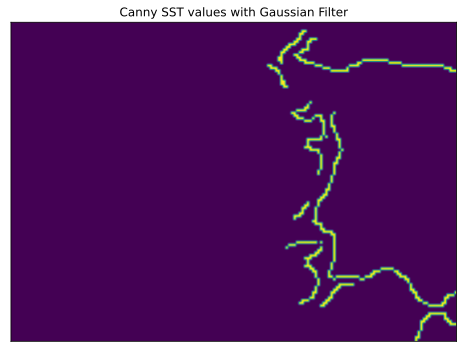

In [23]:
canny_gauss = cv2.Canny(Temp_gauss, 90, 180, L2gradient=False, apertureSize=3)

plt.rcParams["figure.figsize"] = (8,8)

plt.imshow(canny_gauss)   
plt.title('Canny SST values with Gaussian Filter')
plt.xticks([])
plt.yticks([])
    
plt.show()

#### Show difference of results: Normal vs Prior application of a Gaussian Filter

We can observe the differences that appear in the canny results when a Gaussian Filter is previously applied to the array.  Gaussian filter is commonly used in image processing for smoothing and reducing noise.

On StackOverflow they say that if you use an apertureSize greater than 3 (5 or 7) then it is not necessary to apply a Gaussian Blur. If you use an apertureSize=3 then you need to apply a Gaussian Blur first. There are some sources that contradict this information.


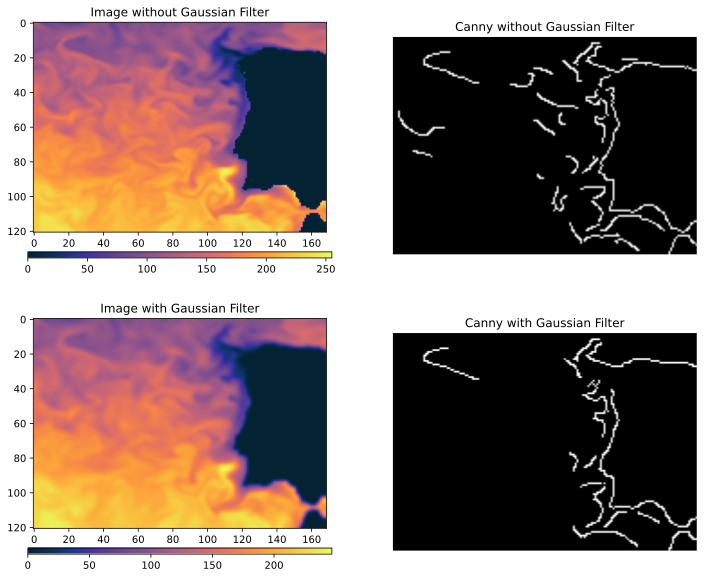

In [24]:
# create figure
fig = plt.figure(figsize=(12, 10))

# setting values to rows and column variables
rows = 2
columns = 2

# Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 1)
im3 = plt.imshow(Temp_aux5, cmocean.cm.thermal);
plt.colorbar(im3, orientation='horizontal', fraction=0.07, pad=0.08, aspect=50);
plt.title('Image without Gaussian Filter');


# Adds a subplot at the 2nd position
fig.add_subplot(rows, columns, 2)
canny_visualization(dia25, 180)
plt.title("Threshold 90-180");
plt.title("Canny without Gaussian Filter");


# Adds a subplot to show the image
ax = fig.add_subplot(rows, columns, 3)
im5 = plt.imshow(Temp_gauss, cmocean.cm.thermal)
plt.colorbar(im5, orientation='horizontal', fraction=0.07, pad=0.08, aspect=50)
plt.title('Image with Gaussian Filter');

fig.add_subplot(rows, columns, 4)
#Definition of canny parameters
canny7 = cv2.Canny(Temp_gauss, 75, 150, L2gradient=False, apertureSize=3)
#apertureSize -> Order of Kernel(matrix) for the Sobel filter. Default value is (3 x 3). value should be odd between 3 and 7
#L2gradient -> specifies the equation for finding gradient magnitude. If True uses a more accurate equation; Default value is False
# With L2gradient=True the algorithm shows less edges
plt.imshow(canny7, 'gray')   
plt.axis('off');
plt.title('Canny with Gaussian Filter');


# ----------------------------------------------------------------------------------------------------

# ------------------------------------------------------------------------------------------
## Overlay the images with the edges detected with Canny

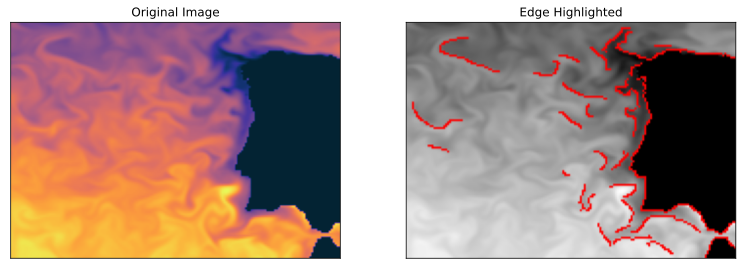

In [25]:

img = Temp_aux5
edges = cv2.Canny(Temp_aux5, 90, 180)   # canny edge detector

fig = plt.subplots(figsize=(13,10))
#plt.rcParams["figure.figsize"] = 12, 20

img = cv2.merge((img,img,img))  # creat RGB image from grayscale
img2 = img.copy()
img2[edges == 255] = [255, 0, 0]  # turn edges to red

plt.subplot(121),plt.imshow(Temp_aux5, cmocean.cm.thermal)
plt.title('Original Image'), plt.xticks([]), plt.yticks([]);
plt.subplot(122),plt.imshow(img2)
plt.title('Edge Highlighted'), plt.xticks([]), plt.yticks([])

plt.show()

# ---------------------------------------------------------------------------
### Finding Oceanic fronts with Edge Detection Techniques

Com este código é possível avaliar como varia a deteção de frentes com a variação dos valores do Threshold

In [26]:
from IPython.display import display
from IPython.html.widgets import interact, fixed

#cbarkw = dict(shrink=0.73, extend='both')

def canny_threshold(image, threshold=50, ratio=3, ksize=3):
    
    #apply canny algorithm
    detected_edges = cv2.Canny(Temp_aux5, threshold,
                               threshold*ratio,
                               apertureSize=ksize)
    # Just add some colours to edges from original data.
    mask = np.ma.masked_equal(detected_edges, 0).mask
    img = np.ma.masked_array(Temp_aux5, mask)
    
    fig, ax = plt.subplots(figsize=(10,8))
    cs = ax.imshow(img)
    #cbar = fig.colorbar(cs, ax=ax, **cbarkw)
    ax.axis('off')
    plt.show()

lims = (0, 100)
w = interact(canny_threshold, threshold=lims,
             image=fixed(Temp_aux5),
             ratio=fixed(3), ksize=fixed(3))

display(w)

/home/luisfigueiredo/.local/lib/python3.8/site-packages/IPython/html.py:12: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  warn("The `IPython.html` package has been deprecated since IPython 4.0. "


interactive(children=(IntSlider(value=50, description='threshold'), Output()), _dom_classes=('widget-interact'…

<function __main__.canny_threshold(image, threshold=50, ratio=3, ksize=3)>

In [27]:
Temp_aux5

array([[124, 124, 116, ..., 117, 117, 118],
       [123, 124, 122, ..., 119, 119, 120],
       [119, 121, 122, ..., 120, 120, 120],
       ...,
       [228, 226, 230, ...,   0,   0,   0],
       [228, 227, 231, ...,   0,   0,   0],
       [228, 227, 231, ...,   0,   0,   0]], dtype=uint8)

# ---------------------------------------------------------------------------------------
## Otsu Method
Is an algorithm to automatically find the optimal threshold intensity

It searches for the threshold intensity that optimally separates the image into two classes (the foreground and the background). Does this by maximizing a matrix called between class variance.
Is optimal in the sense that it does the best possible job to split the foreground and the background assuming a bi-modal distribution of grayscale pixel values.

The Otsu algorithm calculate the high threshold, and then it can be used in the Canny algorithm to detect the object’s edge

Otsu method makes the assumption that the grayscalle histogram of our pixel intensities of our image is bi-modal (the histogram has 2 peaks) --> o que no caso da nossa imagem não é verdade.
If it doesn't follow a bi-modal distribution the Otsu's method may not give us the best results. 

So we should try Adaptive thresholding.

In situations where lighting conditions are semi-stable and the objects we want to segment have sufficient contrast from the background we might not need to use Otsu's method.

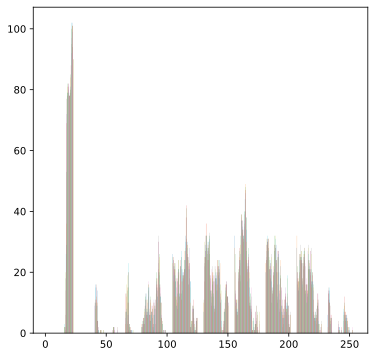

In [28]:
plt.hist(Temp_aux5);

In [29]:
bins_num = 256

#Get the image histogram
hist, bin_edges = np.histogram(Temp_aux5, bins=bins_num)

#Calculate centers of Bins
bin_mids = (bin_edges[:-1] + bin_edges[1:])/2

#iterate through all thresholds (indices) and get the probabilities w1(t), w2(t)
weight1 = np.cumsum(hist)
weight2 = np.cumsum(hist[::-1])[::-1]

#Get the class means mu0(t)
mean1 = np.cumsum(hist*bin_mids)/weight1
#get the class means mu1(t)
mean2 = (np.cumsum((hist*bin_mids)[::-1])/weight2[::-1])[::-1]

inter_class_variance = weight1[:-1]*weight2[1:]*(mean1[:-1] - mean2[1:])**2

#Maximize the inter_class_variance function val
index_of_max_val = np.argmax(inter_class_variance)

threshold = bin_mids[:-1][index_of_max_val]
print('Otsu algorithm implementation thresholding result: ', threshold)

Otsu algorithm implementation thresholding result:  86.162109375


In [50]:
#Another way to get the Otsu's thresolding through the openCV
otsu_threshold, image_result = cv2.threshold(Temp_aux5, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU,)
print('Obtained threshold: ', otsu_threshold)

Obtained threshold:  86.0


In [ ]:
#This value (86) is refering to the high threshold 
